# Goal

- Discover factors relating to customers terminating service with Telco
- Use said factors to develop modeling resources to predict churn

# imports

In [77]:

# My custom modules:
import acquire as a
import prepare as p

# tabular manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Modeling Imports:
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#evaulation metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix


# Acquire


Data was extracted from sequel database using the following function from my imported acquire module

>def get_telco_data()

        - extracts raw data as a dataframe from server with the users env file and a sql query
    
>telco_df.info() 

        - 7043 rows for 7043 customers 
        - 24 columns worth of data for each customer
        - numeric and non-numeric data available covering expenses, tenure, and customer churn

# Prepare Actions
The prepare module incorporates the following to clean data

- prep_telco() makes following changes
    - removed redundant columnss
    - checked for nulls and blank space in data
    - filled blank spaces of with 0.0 where necessary
    - filling in 'None' for null values
 
- encode_telco() makes following changes 
    - converted categorical columns to numerics
    
- splitting_data()
    - divides data into 3 samples for exploration and model processing, stratifying on 'churn'

- no outliers were found

# Explore

In [79]:
#brief review of data
telco_prepped = p.prep_telco(a.get_telco_data()) #fetching clean data directly from raw data
train, validate, test = p.splitting_data(telco_prepped, 'churn') #split data into train, val, and test
train.head()

this file exists, reading csv


,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
2865,4083-BFNYK,Female,1,Yes,No,38,Yes,Yes,Yes,Yes,...,No,No,Yes,No,95.00,3591.25,No,One year,Fiber optic,Credit card (automatic)
4107,5804-LEPIM,Female,1,No,No,2,Yes,No,No,No,...,No,No,No,Yes,70.35,139.05,Yes,Month-to-month,Fiber optic,Electronic check
3453,4895-TMWIR,Male,1,Yes,No,11,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,19.95,214.75,Yes,Month-to-month,None,Mailed check
923,1342-JPNKI,Male,0,No,No,10,Yes,Yes,No,No,...,No,Yes,No,Yes,86.05,834.1,Yes,Month-to-month,Fiber optic,Bank transfer (automatic)
2370,3397-AVTKU,Male,0,No,No,43,Yes,No,No,Yes,...,No,No,Yes,Yes,60.00,2548.55,No,Two year,DSL,Electronic check


## Do longer contract types correlate to higher churn?

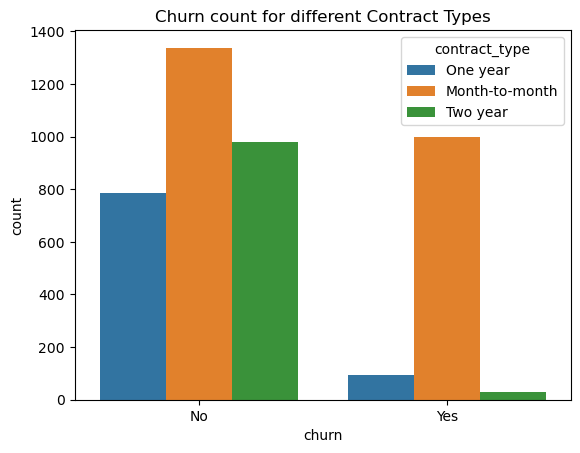

In [80]:
#comparing how many customers churned by contract type
plt.show('Churn count for different Contract Types')

- customers on one-year contracts seem to churn less then month-to-month customers, and two-year customers even less

Let's run a chi squared to compare proportions, to have more confidence

- using a confidence interval of 95%
- and an alpha of 0.05 consequently

$H_0$: "Churn and contract_type are independent."

$H_a$: "There is a relationship between contract_type and churn."

In [82]:
# Run chi-squared test
alpha = 0.05
observed = pd.crosstab(train.churn, train.contract_type)
chi2, p, dof, expected = stats.chi2_contingency(observed)

print("p", p)
print("chi-2", chi2)

p 8.298049251133243e-156
chi-2 714.1745080997528


The p value is less than alpha, therefore we reject the null hypothesis that churn and contract_type are independent. We can assume there is a relationship between contract_type and churn, therefore I would suggest contract_type be used as a feature for model generation

## Does monthly charge correlate to churn?

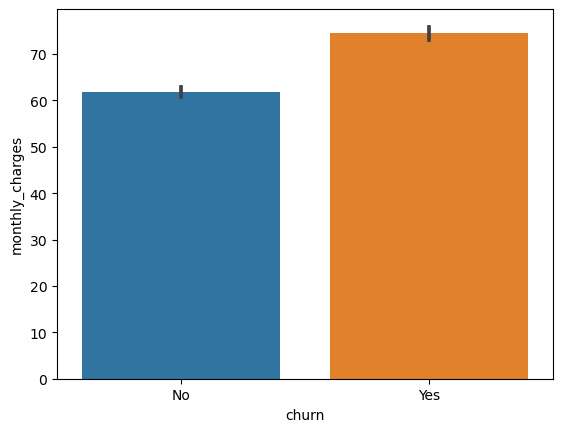

In [83]:
sns.barplot(data = train, x= train.churn, y=train.monthly_charges);
plt.show()

- customers seem more likely to churn when monthly expenses are higher
Let's run a Mann-Whitneyyu Test to compare proportions, to have more confidence

- using a confidence interval of 95%
- and an alpha of 0.05 consequently

$H_0$: "Churn and monthly_charges are independent."

$H_a$: "There is a relationship between monthly_charges and churn."

In [84]:
#Run Mann-Whitneyyu Test
alpha = 0.05
stat, p_value = stats.mannwhitneyu(train[train.churn == 'Yes'].monthly_charges, train[train.churn == 'No'].monthly_charges)

print("Mann-Whitney U test p-value:", p_value)

Mann-Whitney U test p-value: 9.83259830397179e-30


The p value is less than alpha, therefore we reject the null hypothesis that churn and monthly_charges are independent. We can assume there is a relationship between monthly_charges and churn, therefore I would suggest monthly_charges be used as a feature for model generation

## Do customers with phone service churn less?

<Axes: xlabel='phone_service', ylabel='count'>

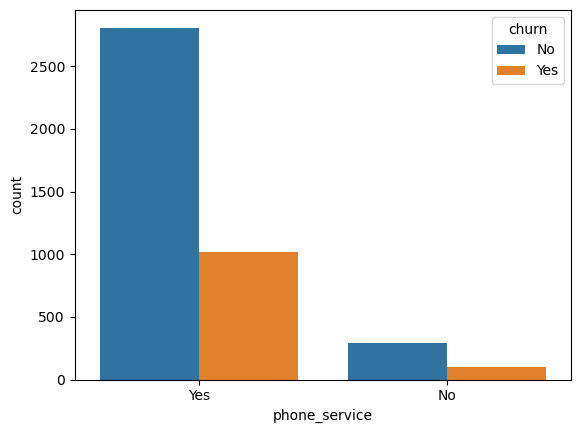

In [71]:
sns.countplot(data = train, x= train.phone_service, hue= train.churn)


- from the plot, the proportion between churn and not churn does not seem to change significantly whether the customer has phone service
Let's run a Mann-Whitneyyu Test to compare proportions, to have more confidence

- using a confidence interval of 95%
- and an alpha of 0.05 consequently

$H_0$: "There is a relationship between phone_service and churn."

$H_a$: "Churn and phone_service are independent."

In [89]:

alpha = 0.05

observed = pd.crosstab(train.churn, train.phone_service)
chi2, p, dof, expected = stats.chi2_contingency(observed)
if p < alpha:
    print("Reject the null hypothesis that")
else:
    print("fail to reject")

print("Mann-Whitney U test p-value:", p)

fail to reject
Mann-Whitney U test p-value: 0.5460166860258362


We can conclude that there is no correlation between phone service and churn.

## Does whether or not customers have internet service correlate with churn?

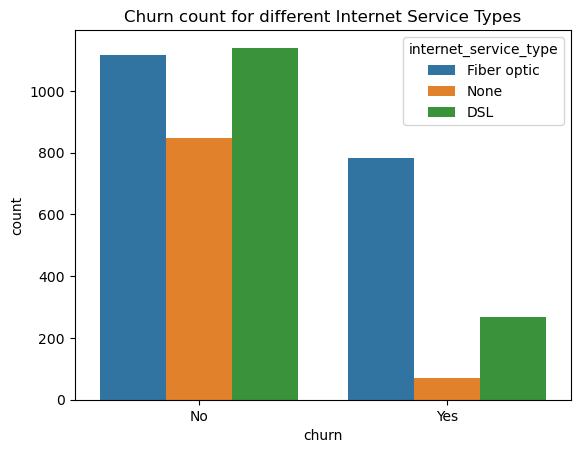

In [73]:
#plotting churn counts for different internet service types

plt.show('Churn count for different Internet Service Types')

- The plot suggests customers without internet service are much less likely to churn.
Let's run a chi squared to compare proportions, to have more confidence

- using a confidence interval of 95%
- and an alpha of 0.05 consequently

$H_0$: "Churn and internet_service_type are independent."

$H_a$: "There is a relationship between internet_service_type and churn."

### Analyze (with stats)

In [90]:
# Run chi-squared
alpha = 0.05
# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.churn, train.internet_service_type)
chi2, p, dof, expected = stats.chi2_contingency(observed)

print("p", p)
print("chi-2", chi2)

p 1.8061078882405112e-91
chi-2 417.88813854093104


The p-value is less than alpha, so we reject the null hypothesis that churn and internet_service_type are independent. Moving forward understanding the relationship, internet_service_type should be implemented as a feature for generating models.

# Model